In [95]:
!pip3 install --quiet matplotlib numpy pandas scikit-learn seaborn prophet plotly

# Data Cleaning

In [96]:
# Basic imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import os
from prophet import Prophet
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import warnings

In [97]:
# ============================================================================
# UTILITY FUNCTIONS
# ============================================================================

# Data loading and preprocessing functions
def load_all_data():
    """Load all raw and processed data files"""
    data = {}
    
    # Load raw data
    data['acorn_details'] = pd.read_csv('data/00_raw/acorn_details.csv', encoding='ISO-8859-1')
    data['temperatures'] = pd.read_csv('data/00_raw/temperatures.csv', sep=';', decimal=',', encoding='utf-8')
    data['uk_bank_holidays'] = pd.read_csv('data/00_raw/uk_bank_holidays.csv')
    data['weather_daily'] = pd.read_csv('data/00_raw/weather_daily_darksky.csv')
    data['weather_hourly'] = pd.read_csv('data/00_raw/weather_hourly_darksky.csv')
    
    # Load processed data from parquet
    data['group_4_daily_predict'] = pd.read_parquet('data/02_processed/parquet/group_4_daily_predict.parquet')
    data['group_4_half_hourly_predict'] = pd.read_parquet('data/02_processed/parquet/group_4_half_hourly_predict.parquet')
    data['group_4_daily'] = pd.read_parquet('data/02_processed/parquet/group_4_daily.parquet')
    data['group_4_half_hourly'] = pd.read_parquet('data/02_processed/parquet/group_4_half_hourly.parquet')
    
    return data

def fix_datetime_formats(data):
    """Fix datetime formats for all datasets"""
    # Fix temperatures datetime
    data['temperatures']['DateTime'] = pd.to_datetime(data['temperatures']['DateTime'], format='mixed')
    
    # Fix bank holidays datetime
    data['uk_bank_holidays']['Bank holidays'] = pd.to_datetime(data['uk_bank_holidays']['Bank holidays'], format='mixed')
    
    # Fix weather daily datetime columns
    datetime_columns = ['temperatureMaxTime', 'temperatureMinTime', 'apparentTemperatureMinTime', 
                       'apparentTemperatureHighTime', 'time', 'sunsetTime', 'sunriseTime', 
                       'temperatureHighTime', 'uvIndexTime', 'temperatureLowTime', 
                       'apparentTemperatureMaxTime', 'apparentTemperatureLowTime']
    
    for col in datetime_columns:
        data['weather_daily'][col] = pd.to_datetime(data['weather_daily'][col])
    
    return data

# Seasonal analysis functions
def get_season(month):
    """Convert month number to season name"""
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:  # months 9, 10, 11
        return 'Fall'

def add_temporal_features(df, datetime_col='DateTime'):
    """Add temporal features to dataframe"""
    df = df.copy()
    df['Hour'] = df[datetime_col].dt.hour
    df['Day'] = df[datetime_col].dt.day_name()
    df['Date'] = df[datetime_col].dt.date
    df['Season'] = df[datetime_col].dt.month.apply(get_season)
    return df

# Plotting utility functions
def create_boxplot_by_acorn(data, y_col='Conso_moy', title_prefix='', figsize=(12, 6)):
    """Create boxplot comparing Acorn groups"""
    plt.figure(figsize=figsize)
    sns.boxplot(x='Acorn', y=y_col, data=data, palette='Set2')
    plt.title(f'{title_prefix} Consumption by Acorn Group')
    plt.xlabel('Acorn Group')
    plt.ylabel('Consumption (kWh)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def create_heatmap_by_acorn(data, acorn_groups, day_order, figsize=(20, 6)):
    """Create heatmaps for each Acorn group showing hour vs day patterns"""
    fig, axes = plt.subplots(1, len(acorn_groups), figsize=figsize)
    
    for idx, acorn in enumerate(acorn_groups):
        # Filter data for current Acorn group
        acorn_data = data[data['Acorn'] == acorn]
        
        # Create pivot table for heatmap
        heatmap_data = acorn_data.pivot_table(index='Hour', columns='Day', values='Conso_moy', aggfunc='mean')
        heatmap_data = heatmap_data.reindex(columns=day_order)
        
        # Create heatmap
        sns.heatmap(heatmap_data, cmap='YlGnBu', annot=True, fmt='.2f', 
                    cbar_kws={'label': 'Average Consumption (kWh)'}, ax=axes[idx])
        axes[idx].set_title(f'Consumption Heatmap - {acorn}')
        axes[idx].set_xlabel('Day of the Week')
        axes[idx].set_ylabel('Hour of the Day')
    
    plt.tight_layout()
    plt.show()

def create_load_duration_curves(data, acorn_groups, figsize=(18, 6)):
    """Create load duration curves for each Acorn group"""
    fig, axes = plt.subplots(1, len(acorn_groups), figsize=figsize)
    
    for idx, acorn_group in enumerate(acorn_groups):
        # Filter data for current Acorn group
        acorn_data = data[data['Acorn'] == acorn_group]
        
        # Sort consumption values in descending order
        sorted_consumption = acorn_data['Conso_moy'].sort_values(ascending=False).reset_index(drop=True)
        
        # Create time duration as percentage (0 to 100%)
        duration_percent = (sorted_consumption.index / len(sorted_consumption)) * 100
        
        # Plot load duration curve
        axes[idx].plot(duration_percent, sorted_consumption, linewidth=2, color='blue')
        axes[idx].set_title(f'Load Duration Curve - {acorn_group}')
        axes[idx].set_xlabel('Duration (%)')
        axes[idx].set_ylabel('Consumption (kWh)')
        axes[idx].grid(True, alpha=0.3)
        axes[idx].set_xlim(0, 100)
    
    plt.tight_layout()
    plt.show()

def create_temporal_boxplots(data, acorn_groups, day_order, figsize=(20, 12)):
    """Create boxplots showing temporal patterns for each Acorn group"""
    fig, axes = plt.subplots(2, len(acorn_groups), figsize=figsize)
    
    for idx, acorn_group in enumerate(acorn_groups):
        acorn_data = data[data['Acorn'] == acorn_group]
        
        # Hour boxplot
        sns.boxplot(x='Hour', y='Conso_moy', data=acorn_data, ax=axes[0, idx], 
                   hue='Hour', palette='viridis', legend=False)
        axes[0, idx].set_title(f'Consumption by Hour - {acorn_group}')
        axes[0, idx].set_xlabel('Hour of Day')
        axes[0, idx].set_ylabel('Consumption (kWh)')
        axes[0, idx].tick_params(axis='x', rotation=45)
        
        # Day of week boxplot
        sns.boxplot(x='Day', y='Conso_moy', data=acorn_data, ax=axes[1, idx], 
                   order=day_order, hue='Day', palette='Set2', legend=False)
        axes[1, idx].set_title(f'Consumption by Day - {acorn_group}')
        axes[1, idx].set_xlabel('Day of Week')
        axes[1, idx].set_ylabel('Consumption (kWh)')
        axes[1, idx].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

def create_seasonal_analysis(data, acorn_groups, season_order, figsize=(16, 20)):
    """Create seasonal subseries analysis plots"""
    fig, axes = plt.subplots(4, 1, figsize=figsize, sharex=True)
    
    for idx, season in enumerate(season_order):
        season_data = data[data['Season'] == season]
        
        for acorn_group in acorn_groups:
            acorn_season_data = season_data[season_data['Acorn'] == acorn_group]
            
            if len(acorn_season_data) > 0:
                # Calculate hourly means for this season and Acorn group
                hourly_means = acorn_season_data.groupby('Hour')['Conso_moy'].mean()
                hourly_std = acorn_season_data.groupby('Hour')['Conso_moy'].std()
                
                # Plot the hourly pattern
                axes[idx].plot(hourly_means.index, hourly_means.values, 
                              marker='o', linewidth=2, markersize=4, 
                              label=acorn_group, alpha=0.8)
                
                # Add confidence intervals
                axes[idx].fill_between(hourly_means.index,
                                      hourly_means.values - hourly_std.values,
                                      hourly_means.values + hourly_std.values,
                                      alpha=0.2)
        
        # Customize each subplot
        axes[idx].set_title(f'{season} - Hourly Consumption Patterns', 
                           fontsize=14, fontweight='bold')
        axes[idx].set_ylabel('Average Consumption (kWh)', fontsize=12)
        axes[idx].grid(True, alpha=0.3)
        axes[idx].legend(title='Acorn Group', loc='upper right')
        axes[idx].set_xticks(range(0, 24, 2))
        axes[idx].set_xlim(0, 23)
    
    axes[3].set_xlabel('Hour of Day', fontsize=12)
    plt.suptitle('Seasonal Subseries: Hourly Consumption Patterns by Season', 
                 fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()

def print_seasonal_summary(data, acorn_groups, season_order):
    """Print seasonal summary statistics"""
    print("\n=== SEASONAL SUBSERIES ANALYSIS ===")
    print("Peak hours and consumption levels by season and Acorn group:")
    
    for season in season_order:
        print(f"\n--- {season.upper()} ---")
        season_data = data[data['Season'] == season]
        
        for acorn_group in acorn_groups:
            acorn_season_data = season_data[season_data['Acorn'] == acorn_group]
            
            if len(acorn_season_data) > 0:
                hourly_means = acorn_season_data.groupby('Hour')['Conso_moy'].mean()
                
                # Find peak and minimum hours
                peak_hour = hourly_means.idxmax()
                min_hour = hourly_means.idxmin()
                peak_consumption = hourly_means.max()
                min_consumption = hourly_means.min()
                
                print(f"{acorn_group}: Peak at {peak_hour:02d}:00 ({peak_consumption:.3f} kWh), "
                      f"Min at {min_hour:02d}:00 ({min_consumption:.3f} kWh)")

# Anomaly detection functions
def prepare_daily_consumption(data):
    """Prepare daily consumption data for anomaly detection"""
    daily_consumption = data.groupby(['Acorn', 'Date'])['Conso_moy'].agg([
        'sum', 'mean', 'std', 'min', 'max'
    ]).reset_index()
    daily_consumption.columns = ['Acorn', 'Date', 'Daily_Sum', 'Daily_Mean', 'Daily_Std', 'Daily_Min', 'Daily_Max']
    
    # Add temporal features
    daily_consumption['Day_of_Week'] = daily_consumption['Date'].dt.dayofweek
    daily_consumption['Month'] = daily_consumption['Date'].dt.month
    daily_consumption['Is_Weekend'] = (daily_consumption['Day_of_Week'] >= 5).astype(int)
    daily_consumption['Season'] = daily_consumption['Month'].apply(get_season)
    
    # Add season numeric mapping
    season_mapping = {'Winter': 0, 'Spring': 1, 'Summer': 2, 'Fall': 3}
    daily_consumption['Season_Numeric'] = daily_consumption['Season'].map(season_mapping)
    
    return daily_consumption

def add_holiday_features(daily_consumption, holidays_df):
    """Add holiday features to daily consumption data"""
    daily_consumption['Is_Holiday'] = daily_consumption['Date'].isin(holidays_df['ds']).astype(int)
    return daily_consumption

def perform_isolation_forest_detection(data, features, contamination=0.1):
    """Perform Isolation Forest anomaly detection"""
    from sklearn.ensemble import IsolationForest
    from sklearn.preprocessing import StandardScaler
    
    # Handle missing values
    data_clean = data.copy()
    data_clean['Daily_Std'] = data_clean['Daily_Std'].fillna(0)
    
    X = data_clean[features]
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Apply Isolation Forest
    iso_forest = IsolationForest(contamination=contamination, random_state=42)
    data_clean['Isolation_Anomaly'] = iso_forest.fit_predict(X_scaled)
    data_clean['Isolation_Score'] = iso_forest.score_samples(X_scaled)
    data_clean['Is_Isolation_Anomaly'] = data_clean['Isolation_Anomaly'] == -1
    
    return data_clean

def perform_prophet_detection(data, holidays_df):
    """Perform Prophet-based anomaly detection"""
    from prophet import Prophet
    
    # Prepare data for Prophet
    prophet_data = data[['Date', 'Daily_Sum']].copy()
    prophet_data.columns = ['ds', 'y']
    
    # Initialize and fit Prophet model
    model = Prophet(
        holidays=holidays_df,
        daily_seasonality=False,
        weekly_seasonality=True,
        yearly_seasonality=True,
        seasonality_mode='multiplicative',
        interval_width=0.95
    )
    
    model.fit(prophet_data)
    forecast = model.predict(prophet_data)
    
    # Calculate residuals and anomalies
    data_result = data.copy()
    data_result['Prophet_Predicted'] = forecast['yhat'].values
    data_result['Prophet_Lower'] = forecast['yhat_lower'].values
    data_result['Prophet_Upper'] = forecast['yhat_upper'].values
    data_result['Prophet_Residual'] = data_result['Daily_Sum'] - data_result['Prophet_Predicted']
    
    # Define anomalies
    data_result['Is_Prophet_Anomaly'] = (
        (data_result['Daily_Sum'] < data_result['Prophet_Lower']) | 
        (data_result['Daily_Sum'] > data_result['Prophet_Upper'])
    )
    
    # Calculate anomaly severity
    data_result['Prophet_Anomaly_Severity'] = np.maximum(
        data_result['Prophet_Lower'] - data_result['Daily_Sum'],
        data_result['Daily_Sum'] - data_result['Prophet_Upper']
    ) / (data_result['Prophet_Upper'] - data_result['Prophet_Lower'])
    data_result['Prophet_Anomaly_Severity'] = np.maximum(0, data_result['Prophet_Anomaly_Severity'])
    
    return data_result

def create_anomaly_visualization(anomaly_results, acorn_groups, figsize=(24, 20)):
    """Create comprehensive anomaly detection visualization"""
    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(4, 3, hspace=0.3, wspace=0.3)
    
    for idx, acorn_group in enumerate(acorn_groups):
        acorn_data = anomaly_results[acorn_group]
        
        # Plot 1: Time series with forecasts and anomalies
        ax1 = fig.add_subplot(gs[0, idx])
        
        # Plot actual consumption
        ax1.plot(acorn_data['Date'], acorn_data['Daily_Sum'], 'b-', label='Actual', alpha=0.7)
        
        # Plot Prophet forecast
        ax1.plot(acorn_data['Date'], acorn_data['Prophet_Predicted'], 'g--', label='Prophet Forecast')
        ax1.fill_between(acorn_data['Date'], 
                        acorn_data['Prophet_Lower'], 
                        acorn_data['Prophet_Upper'], 
                        alpha=0.3, color='green', label='Confidence Interval')
        
        # Highlight anomalies
        prophet_anomalies = acorn_data[acorn_data['Is_Prophet_Anomaly']]
        isolation_anomalies = acorn_data[acorn_data['Is_Isolation_Anomaly']]
        
        if len(prophet_anomalies) > 0:
            ax1.scatter(prophet_anomalies['Date'], prophet_anomalies['Daily_Sum'], 
                       color='red', s=50, label='Prophet Anomalies', zorder=5)
        
        if len(isolation_anomalies) > 0:
            ax1.scatter(isolation_anomalies['Date'], isolation_anomalies['Daily_Sum'], 
                       color='orange', s=30, marker='^', label='Isolation Anomalies', zorder=4)
        
        # Mark holidays
        holiday_data = acorn_data[acorn_data['Is_Holiday'] == 1]
        if len(holiday_data) > 0:
            ax1.scatter(holiday_data['Date'], holiday_data['Daily_Sum'], 
                       color='purple', s=80, marker='*', label='Bank Holidays', zorder=6)
        
        ax1.set_title(f'Anomaly Detection - {acorn_group}', fontweight='bold')
        ax1.set_ylabel('Daily Consumption (kWh)')
        ax1.legend(fontsize=8)
        ax1.grid(True, alpha=0.3)
        
        # Plot 2: Anomaly scores distribution
        ax2 = fig.add_subplot(gs[1, idx])
        ax2.hist(acorn_data['Isolation_Score'], bins=30, alpha=0.7, 
                label='Isolation Scores', color='orange')
        ax2.axvline(acorn_data[acorn_data['Is_Isolation_Anomaly']]['Isolation_Score'].max(), 
                   color='red', linestyle='--', label='Anomaly Threshold')
        ax2.set_title(f'Isolation Forest Scores - {acorn_group}')
        ax2.set_xlabel('Anomaly Score')
        ax2.set_ylabel('Frequency')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # Plot 3: Residuals analysis
        ax3 = fig.add_subplot(gs[2, idx])
        ax3.scatter(acorn_data['Date'], acorn_data['Prophet_Residual'], 
                   alpha=0.6, color='blue', s=20)
        
        if len(prophet_anomalies) > 0:
            ax3.scatter(prophet_anomalies['Date'], prophet_anomalies['Prophet_Residual'], 
                       color='red', s=50, label='Prophet Anomalies')
        
        ax3.axhline(y=0, color='black', linestyle='-', alpha=0.5)
        
        residual_std = acorn_data['Prophet_Residual'].std()
        ax3.axhline(y=2*residual_std, color='red', linestyle='--', alpha=0.5, label='±2σ')
        ax3.axhline(y=-2*residual_std, color='red', linestyle='--', alpha=0.5)
        
        ax3.set_title(f'Prophet Residuals - {acorn_group}')
        ax3.set_ylabel('Residuals (kWh)')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        
        # Plot 4: Monthly anomaly rates
        ax4 = fig.add_subplot(gs[3, idx])
        
        acorn_data['Year_Month'] = acorn_data['Date'].dt.to_period('M')
        monthly_anomalies = acorn_data.groupby('Year_Month').agg({
            'Is_Combined_Anomaly': 'sum',
            'Date': 'count'
        }).reset_index()
        monthly_anomalies['Anomaly_Rate'] = monthly_anomalies['Is_Combined_Anomaly'] / monthly_anomalies['Date']
        
        ax4.bar(range(len(monthly_anomalies)), monthly_anomalies['Anomaly_Rate'], 
               color='red', alpha=0.7)
        ax4.set_title(f'Monthly Anomaly Rate - {acorn_group}')
        ax4.set_ylabel('Anomaly Rate')
        ax4.set_xlabel('Month')
        ax4.set_xticks(range(0, len(monthly_anomalies), 3))
        ax4.set_xticklabels([str(monthly_anomalies.iloc[i]['Year_Month']) 
                            for i in range(0, len(monthly_anomalies), 3)], rotation=45)
        ax4.grid(True, alpha=0.3)
    
    plt.suptitle('Comprehensive Anomaly Detection Analysis', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

def print_anomaly_summary(anomaly_results, acorn_groups):
    """Print comprehensive anomaly detection summary"""
    print("\n" + "="*80)
    print("DETAILED ANOMALY ANALYSIS")
    print("="*80)
    
    # Create summary table
    summary_data = []
    for acorn_group in acorn_groups:
        data = anomaly_results[acorn_group]
        
        summary_data.append({
            'Acorn_Group': acorn_group,
            'Total_Days': len(data),
            'Isolation_Anomalies': data['Is_Isolation_Anomaly'].sum(),
            'Prophet_Anomalies': data['Is_Prophet_Anomaly'].sum(),
            'Combined_Anomalies': data['Is_Combined_Anomaly'].sum(),
            'Holiday_Days': data['Is_Holiday'].sum(),
            'Holiday_Anomalies': data[data['Is_Holiday'] == 1]['Is_Combined_Anomaly'].sum(),
            'Avg_Daily_Consumption': data['Daily_Sum'].mean(),
            'Consumption_Std': data['Daily_Sum'].std()
        })
    
    summary_df = pd.DataFrame(summary_data)
    summary_df['Isolation_Rate'] = (summary_df['Isolation_Anomalies'] / summary_df['Total_Days'] * 100).round(2)
    summary_df['Prophet_Rate'] = (summary_df['Prophet_Anomalies'] / summary_df['Total_Days'] * 100).round(2)
    summary_df['Combined_Rate'] = (summary_df['Combined_Anomalies'] / summary_df['Total_Days'] * 100).round(2)
    summary_df['Holiday_Anomaly_Rate'] = (summary_df['Holiday_Anomalies'] / summary_df['Holiday_Days'] * 100).round(2)
    
    print("\nANOMALY DETECTION SUMMARY:")
    print(summary_df[['Acorn_Group', 'Total_Days', 'Isolation_Rate', 'Prophet_Rate', 
                     'Combined_Rate', 'Holiday_Anomaly_Rate']].to_string(index=False))
    
    return summary_df

# Global constants
DAY_ORDER = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
SEASON_ORDER = ['Winter', 'Spring', 'Summer', 'Fall']
ANOMALY_FEATURES = ['Daily_Sum', 'Daily_Mean', 'Daily_Std', 'Day_of_Week', 
                   'Month', 'Is_Weekend', 'Is_Holiday', 'Season_Numeric']

In [98]:
# Changing the path to the root of the repository

if not os.path.exists('data'):
    current_path = os.getcwd()
    root_path = os.path.abspath(os.path.join(current_path, '..'))
    os.chdir(root_path)
    print(f'Changed working directory to: {os.getcwd()}')

In [99]:
# Load all data using utility function
data = load_all_data()

# Extract individual datasets for backward compatibility
acorn_details = data['acorn_details']
temperatures = data['temperatures']
uk_bank_holidays = data['uk_bank_holidays']
weather_daily = data['weather_daily']
weather_hourly = data['weather_hourly']
group_4_daily_predict = data['group_4_daily_predict']
group_4_half_hourly_predict = data['group_4_half_hourly_predict']
group_4_daily = data['group_4_daily']
group_4_half_hourly = data['group_4_half_hourly']

In [100]:
# Fix datetime formats using utility function
data = fix_datetime_formats(data)

# Update individual variables
temperatures = data['temperatures']
uk_bank_holidays = data['uk_bank_holidays']
weather_daily = data['weather_daily']

# Conso by Acorn - Hourly

## Different Granularities

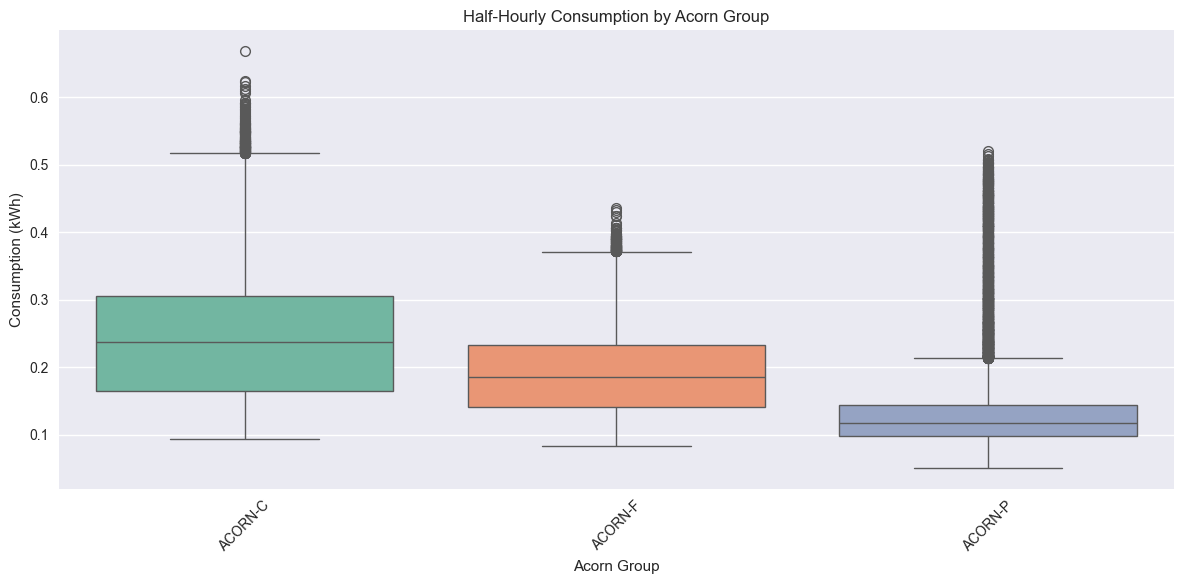

In [101]:
# Conso by Acorn group (half-hourly)
# Copying
group_4_half_hourly = group_4_half_hourly.copy()
group_4_half_hourly['Acorn'] = group_4_half_hourly['Acorn'].astype('category')

# Prepare data with temporal features
group_4_half_hourly = add_temporal_features(group_4_half_hourly)

# Create boxplot using utility function
create_boxplot_by_acorn(group_4_half_hourly, title_prefix='Half-Hourly')

# Get Acorn groups for later use
acorn_groups = group_4_half_hourly['Acorn'].unique()

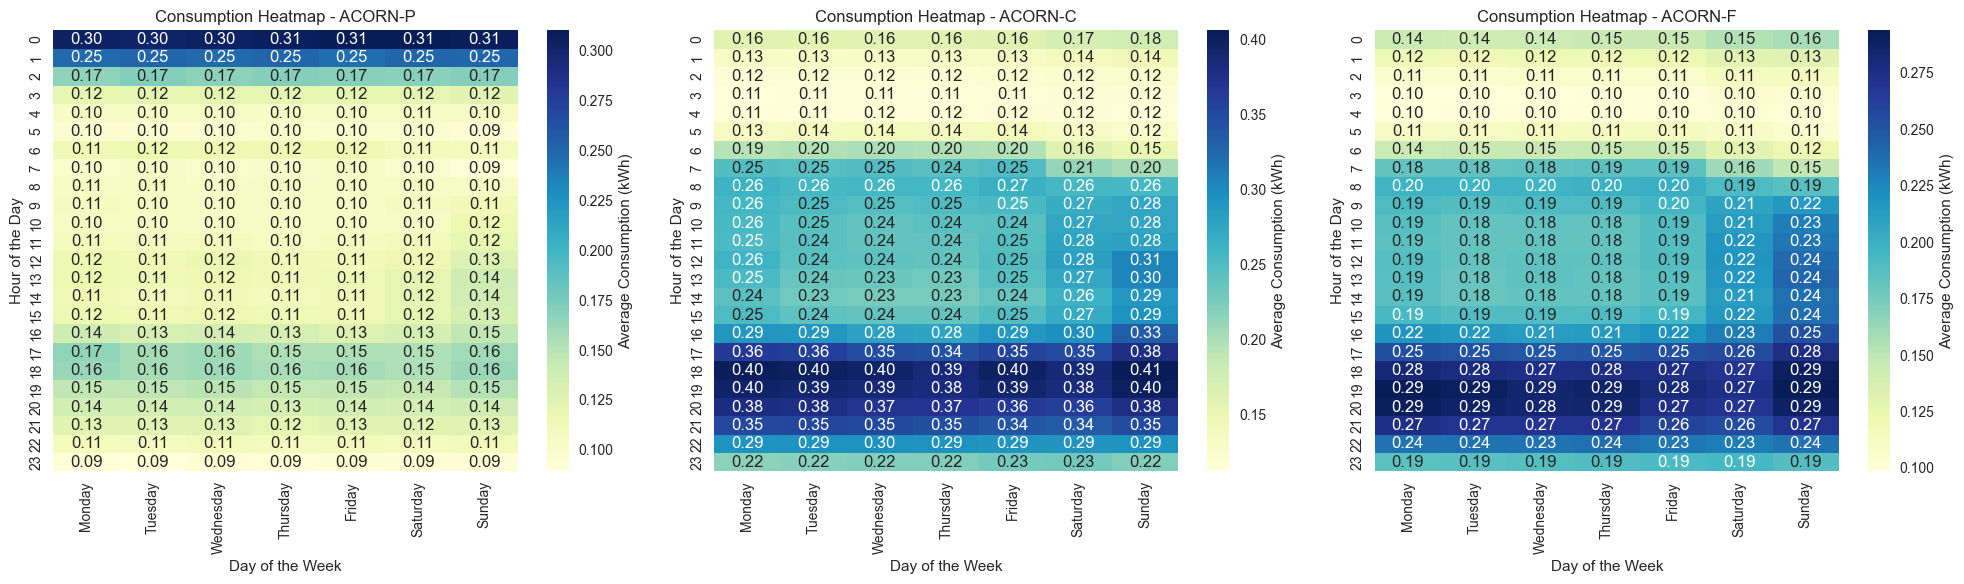

In [102]:
# Create separate heatmaps for each Acorn group
acorn_groups = group_4_half_hourly['Acorn'].unique()

# Define the correct order for days
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Extract hour and day from DateTime
group_4_half_hourly['Hour'] = group_4_half_hourly['DateTime'].dt.hour
group_4_half_hourly['Day'] = group_4_half_hourly['DateTime'].dt.day_name()

# Create heatmaps using utility function
create_heatmap_by_acorn(group_4_half_hourly, acorn_groups, day_order)

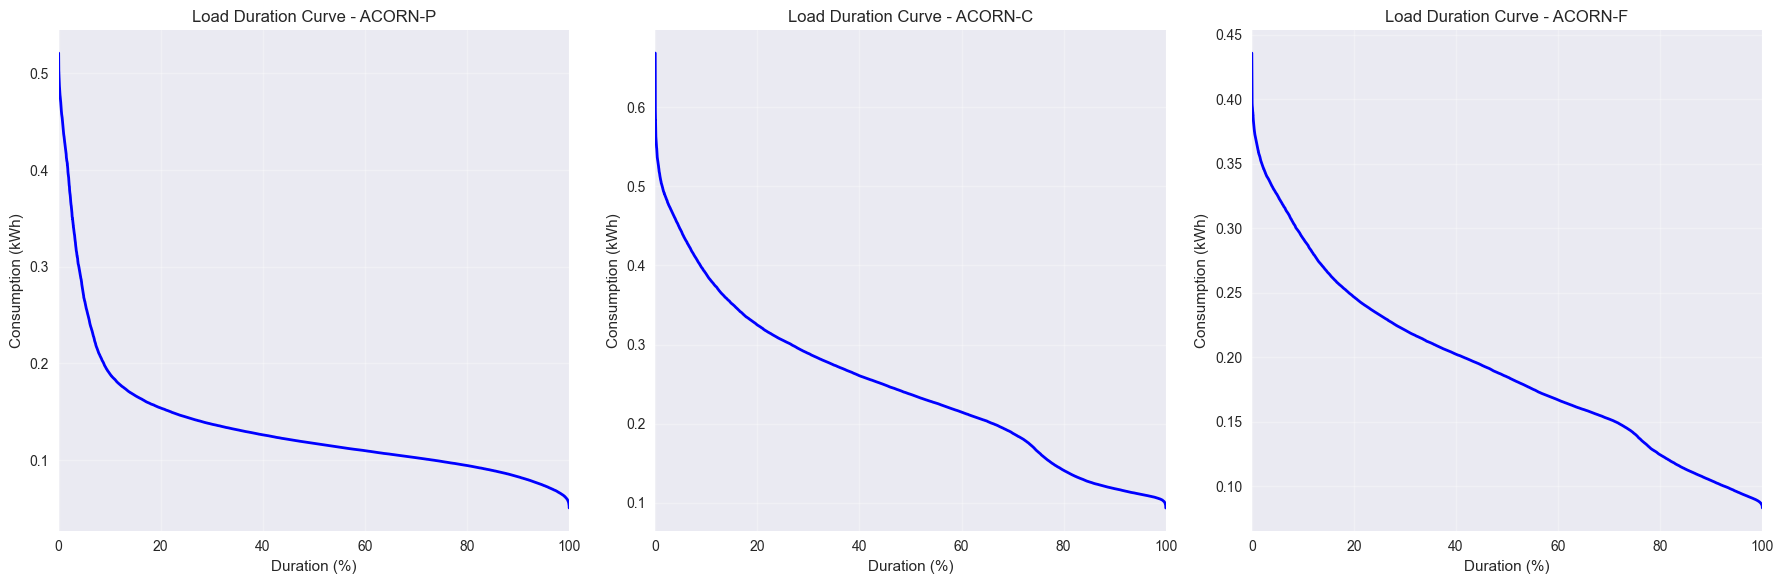

In [103]:
# Load Duration Curves
create_load_duration_curves(group_4_half_hourly, acorn_groups)

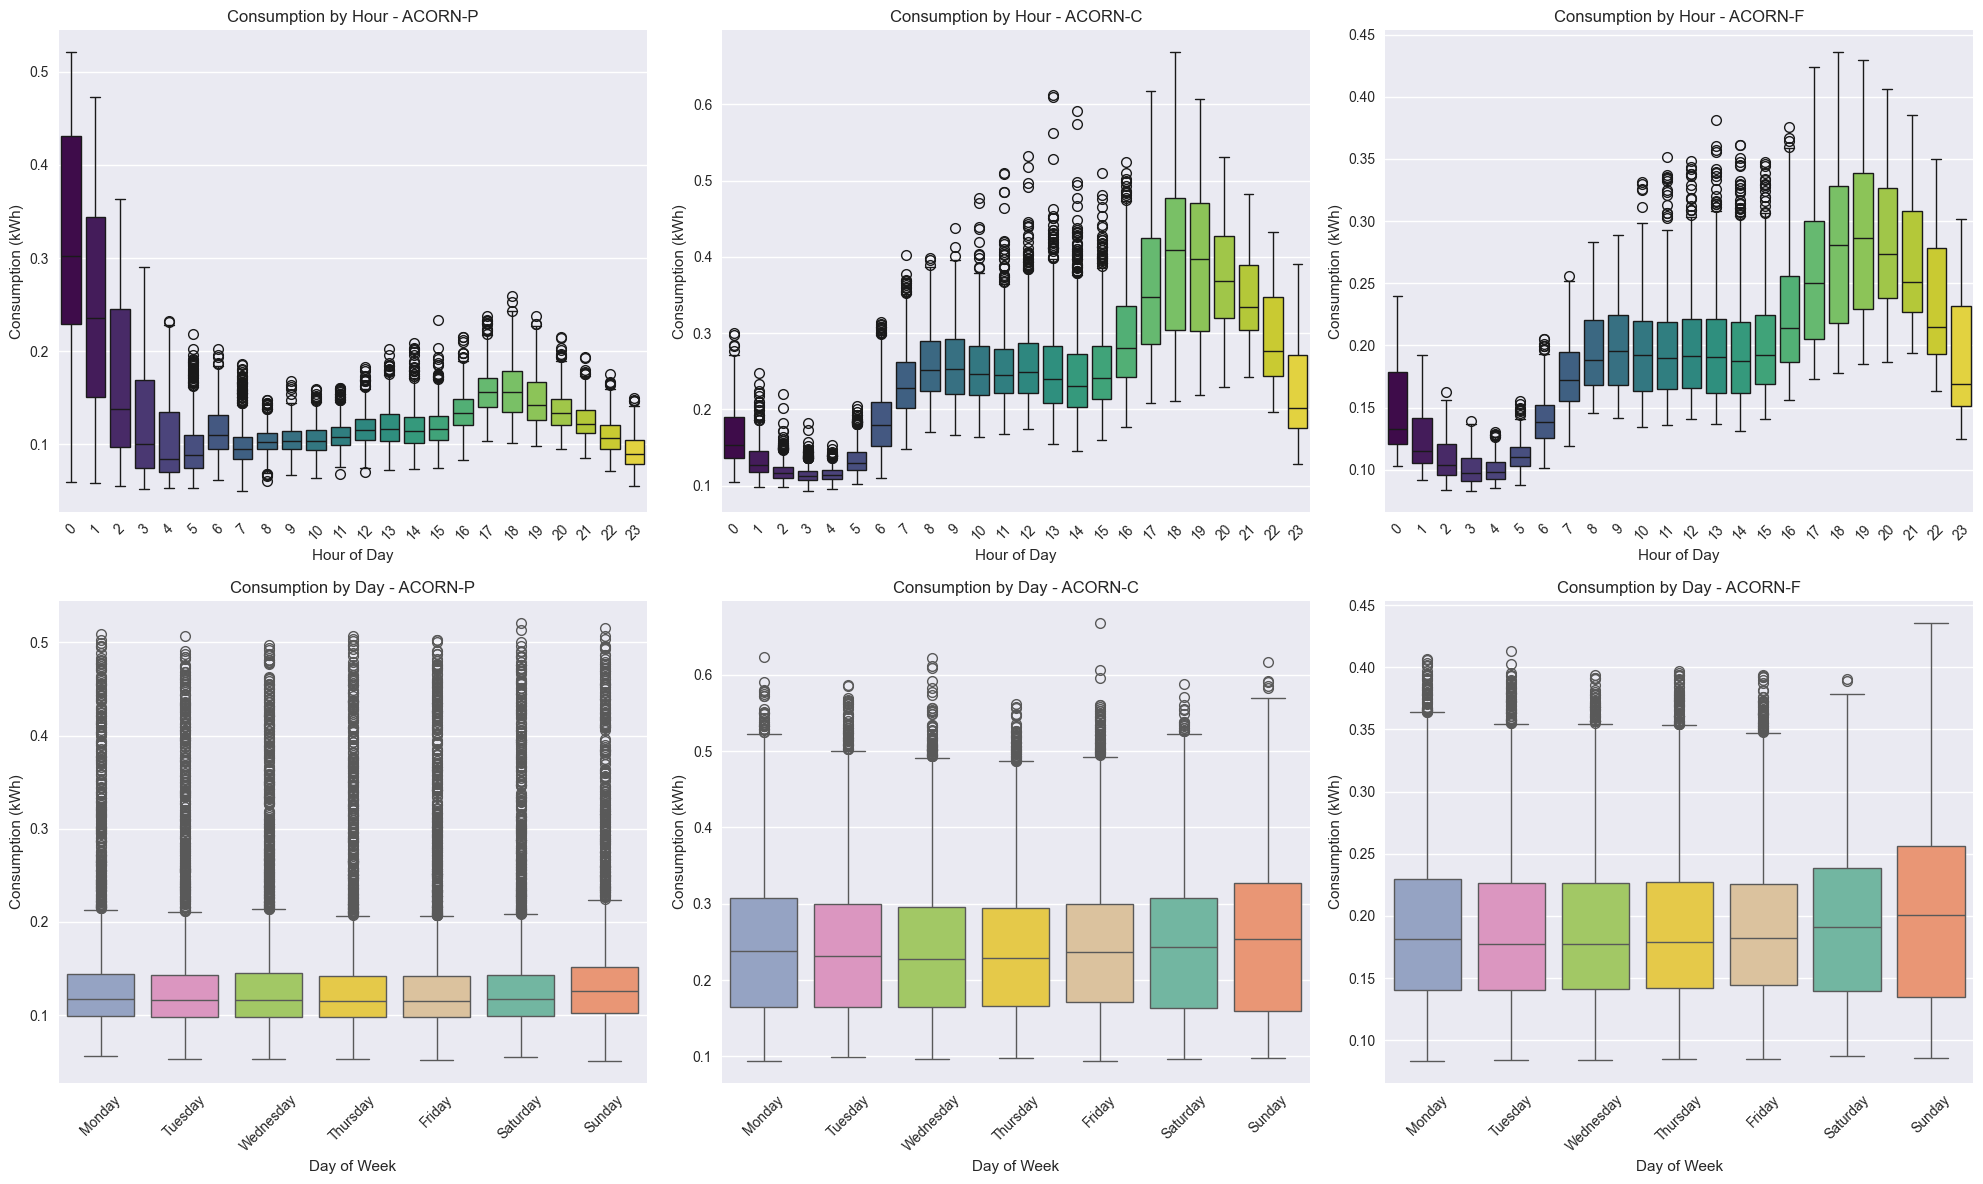

In [104]:
# Boxplots of hour of day/day of week consumption for each Acorn group
create_temporal_boxplots(group_4_half_hourly, acorn_groups, DAY_ORDER)

## Seasonality and Events

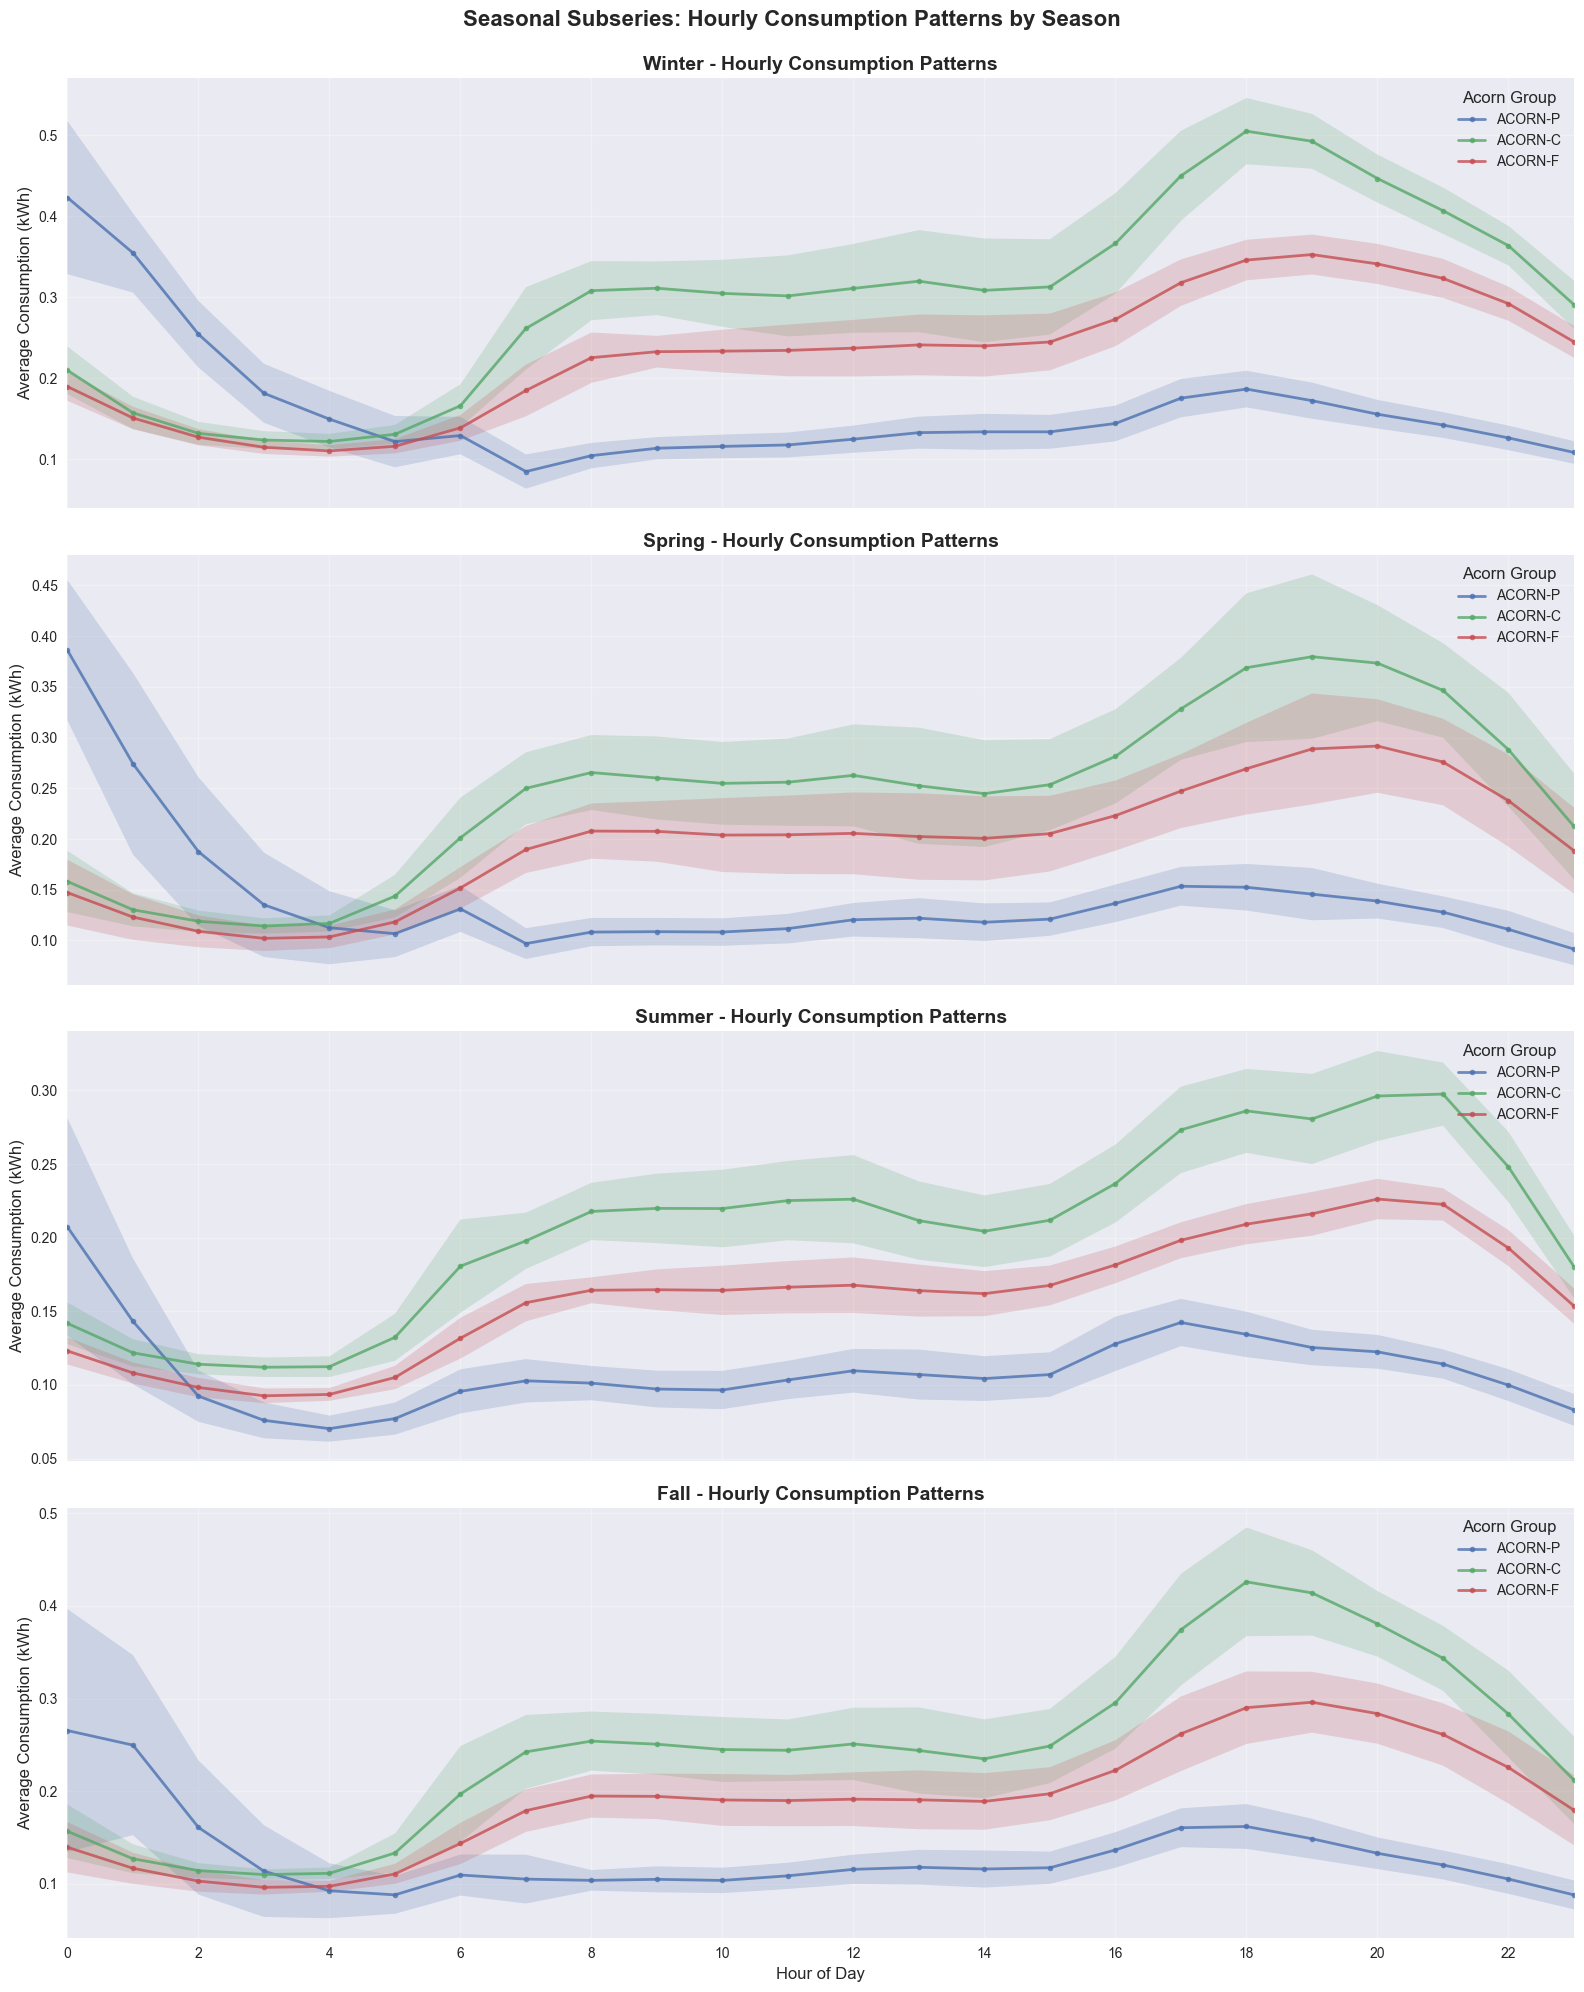


=== SEASONAL SUBSERIES ANALYSIS ===
Peak hours and consumption levels by season and Acorn group:

--- WINTER ---
ACORN-P: Peak at 00:00 (0.423 kWh), Min at 07:00 (0.085 kWh)
ACORN-C: Peak at 18:00 (0.505 kWh), Min at 04:00 (0.122 kWh)
ACORN-F: Peak at 19:00 (0.353 kWh), Min at 04:00 (0.110 kWh)

--- SPRING ---
ACORN-P: Peak at 00:00 (0.386 kWh), Min at 23:00 (0.091 kWh)
ACORN-C: Peak at 19:00 (0.380 kWh), Min at 03:00 (0.114 kWh)
ACORN-F: Peak at 20:00 (0.292 kWh), Min at 03:00 (0.102 kWh)

--- SUMMER ---
ACORN-P: Peak at 00:00 (0.207 kWh), Min at 04:00 (0.070 kWh)
ACORN-C: Peak at 21:00 (0.297 kWh), Min at 03:00 (0.112 kWh)
ACORN-F: Peak at 20:00 (0.226 kWh), Min at 03:00 (0.093 kWh)

--- FALL ---
ACORN-P: Peak at 00:00 (0.265 kWh), Min at 23:00 (0.088 kWh)
ACORN-C: Peak at 18:00 (0.426 kWh), Min at 03:00 (0.110 kWh)
ACORN-F: Peak at 19:00 (0.296 kWh), Min at 03:00 (0.096 kWh)


In [110]:
# Seasonal subseries plot - showing hourly patterns within each season

# Create seasonal analysis using utility function
create_seasonal_analysis(group_4_half_hourly, acorn_groups, SEASON_ORDER)

# Print seasonal summary using utility function
print_seasonal_summary(group_4_half_hourly, acorn_groups, SEASON_ORDER)

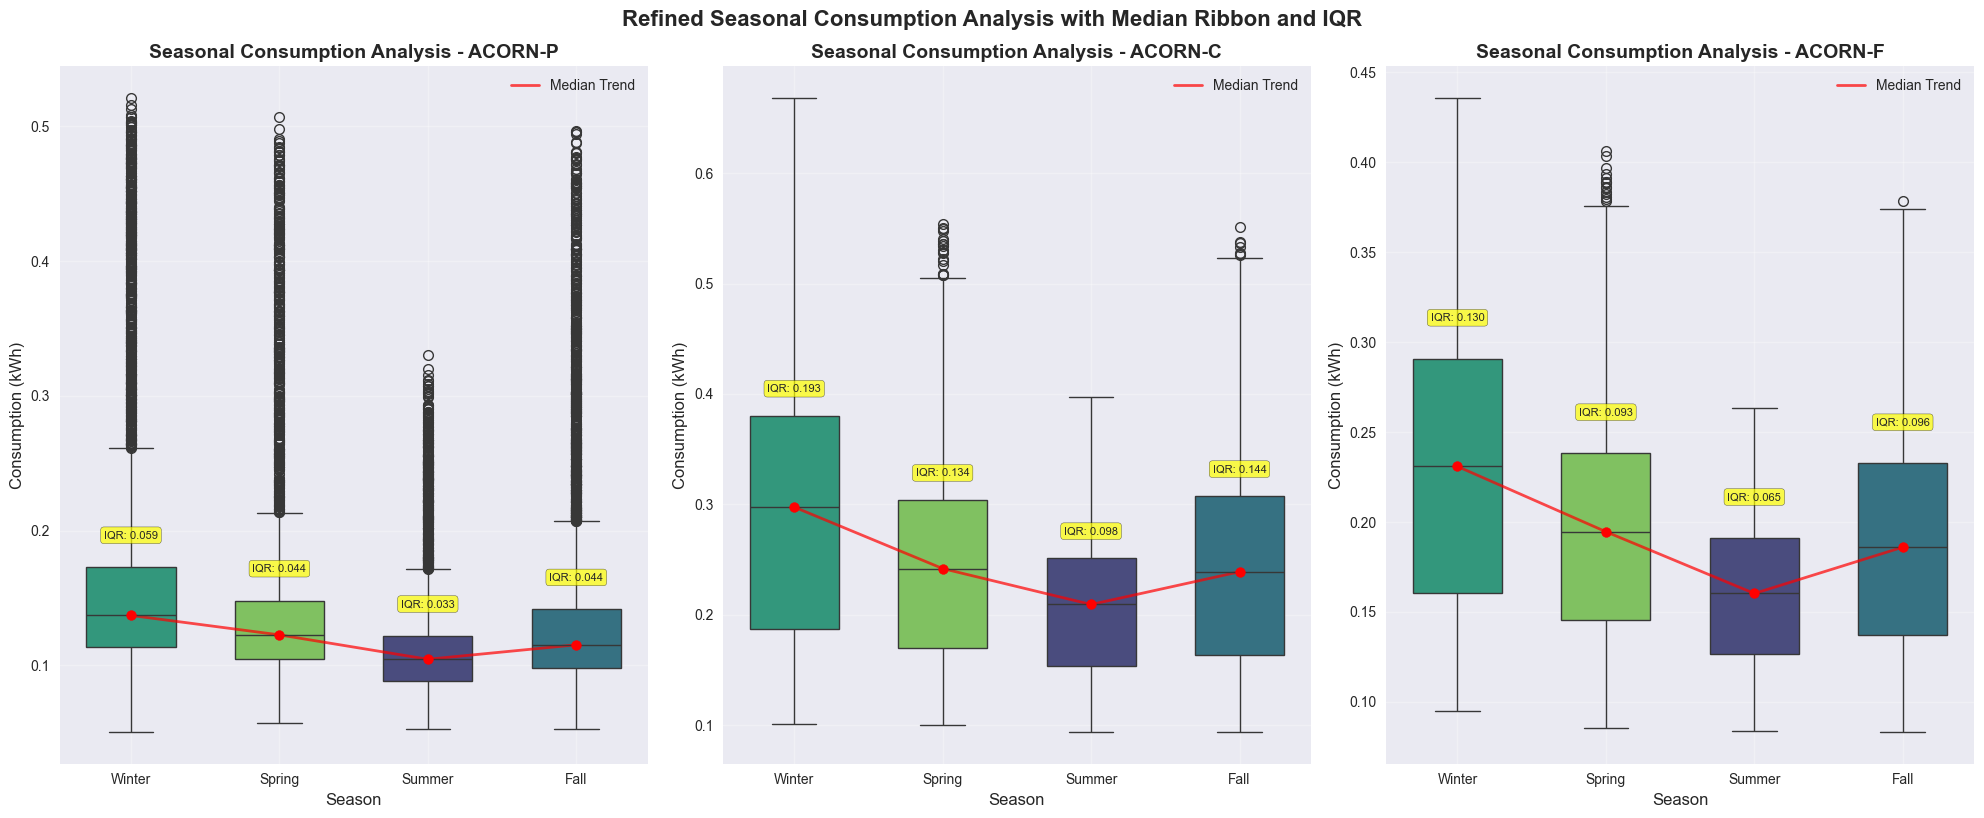


=== SEASONAL CONSUMPTION STATISTICS ===

Summary by Acorn Group and Season:

--- ACORN-P ---
        Count    Mean  Median     Std      Q1      Q3     IQR
Season                                                       
Fall     8736  0.1303  0.1153  0.0604  0.0978  0.1416  0.0438
Spring   4416  0.1419  0.1227  0.0713  0.1044  0.1481  0.0437
Summer   7396  0.1100  0.1046  0.0354  0.0887  0.1218  0.0331
Winter   6384  0.1617  0.1371  0.0831  0.1140  0.1728  0.0588

--- ACORN-C ---
        Count    Mean  Median     Std      Q1      Q3     IQR
Season                                                       
Fall     8736  0.2456  0.2389  0.0994  0.1631  0.3074  0.1443
Spring   4416  0.2442  0.2418  0.0924  0.1695  0.3039  0.1344
Summer   7396  0.2062  0.2092  0.0626  0.1533  0.2511  0.0978
Winter   6384  0.2959  0.2975  0.1209  0.1873  0.3802  0.1929

--- ACORN-F ---
        Count    Mean  Median     Std      Q1      Q3     IQR
Season                                                       
Fall

In [106]:
# Refined boxplots by season with median ribbon and interquartile range

# First, add season column to the data
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:  # months 9, 10, 11
        return 'Fall'

# Add season column
group_4_half_hourly['Season'] = group_4_half_hourly['DateTime'].dt.month.apply(get_season)

# Define season order for plotting
SEASON_ORDER = ['Winter', 'Spring', 'Summer', 'Fall']

# Create refined boxplots by season for each Acorn group
fig, axes = plt.subplots(1, 3, figsize=(20, 8))

for idx, acorn_group in enumerate(acorn_groups):
    acorn_data = group_4_half_hourly[group_4_half_hourly['Acorn'] == acorn_group]
    
    # Create boxplot with enhanced styling
    box_plot = sns.boxplot(x='Season', y='Conso_moy', data=acorn_data, 
                          order=SEASON_ORDER, ax=axes[idx], 
                          hue='Season', palette='viridis', width=0.6, legend=False)
    
    # Calculate statistics for each season
    season_stats = []
    for season in SEASON_ORDER:
        season_data = acorn_data[acorn_data['Season'] == season]['Conso_moy']
        if len(season_data) > 0:
            q1 = season_data.quantile(0.25)
            q3 = season_data.quantile(0.75)
            median = season_data.median()
            season_stats.append({'season': season, 'q1': q1, 'q3': q3, 'median': median})
    
    # Add median ribbon (connecting medians)
    if len(season_stats) > 1:
        x_positions = range(len(SEASON_ORDER))
        medians = [stat['median'] for stat in season_stats]
        axes[idx].plot(x_positions, medians, 'r-', linewidth=2, alpha=0.7, label='Median Trend')
        axes[idx].scatter(x_positions, medians, color='red', s=50, zorder=5)
    
    # Add interquartile range ribbons
    for i, stat in enumerate(season_stats):
        # Add subtle fill between Q1 and Q3
        axes[idx].fill_between([i-0.3, i+0.3], [stat['q1'], stat['q1']], 
                              [stat['q3'], stat['q3']], alpha=0.2, color='lightblue')
    
    # Customize the plot
    axes[idx].set_title(f'Seasonal Consumption Analysis - {acorn_group}', fontsize=14, fontweight='bold')
    axes[idx].set_xlabel('Season', fontsize=12)
    axes[idx].set_ylabel('Consumption (kWh)', fontsize=12)
    axes[idx].grid(True, alpha=0.3)
    axes[idx].legend()
    
    # Add statistical annotations
    for i, stat in enumerate(season_stats):
        # Add text with IQR information
        iqr = stat['q3'] - stat['q1']
        axes[idx].text(i, stat['q3'] + 0.02, f'IQR: {iqr:.3f}', 
                      ha='center', va='bottom', fontsize=8, 
                      bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))

plt.tight_layout()
plt.suptitle('Refined Seasonal Consumption Analysis with Median Ribbon and IQR', 
             fontsize=16, fontweight='bold', y=1.02)
plt.show()

# Print summary statistics by season
print("\n=== SEASONAL CONSUMPTION STATISTICS ===")
print("\nSummary by Acorn Group and Season:")
for acorn_group in acorn_groups:
    print(f"\n--- {acorn_group} ---")
    acorn_data = group_4_half_hourly[group_4_half_hourly['Acorn'] == acorn_group]
    seasonal_summary = acorn_data.groupby('Season')['Conso_moy'].agg([
        'count', 'mean', 'median', 'std', 
        lambda x: x.quantile(0.25), 
        lambda x: x.quantile(0.75)
    ]).round(4)
    seasonal_summary.columns = ['Count', 'Mean', 'Median', 'Std', 'Q1', 'Q3']
    seasonal_summary['IQR'] = (seasonal_summary['Q3'] - seasonal_summary['Q1']).round(4)
    print(seasonal_summary)

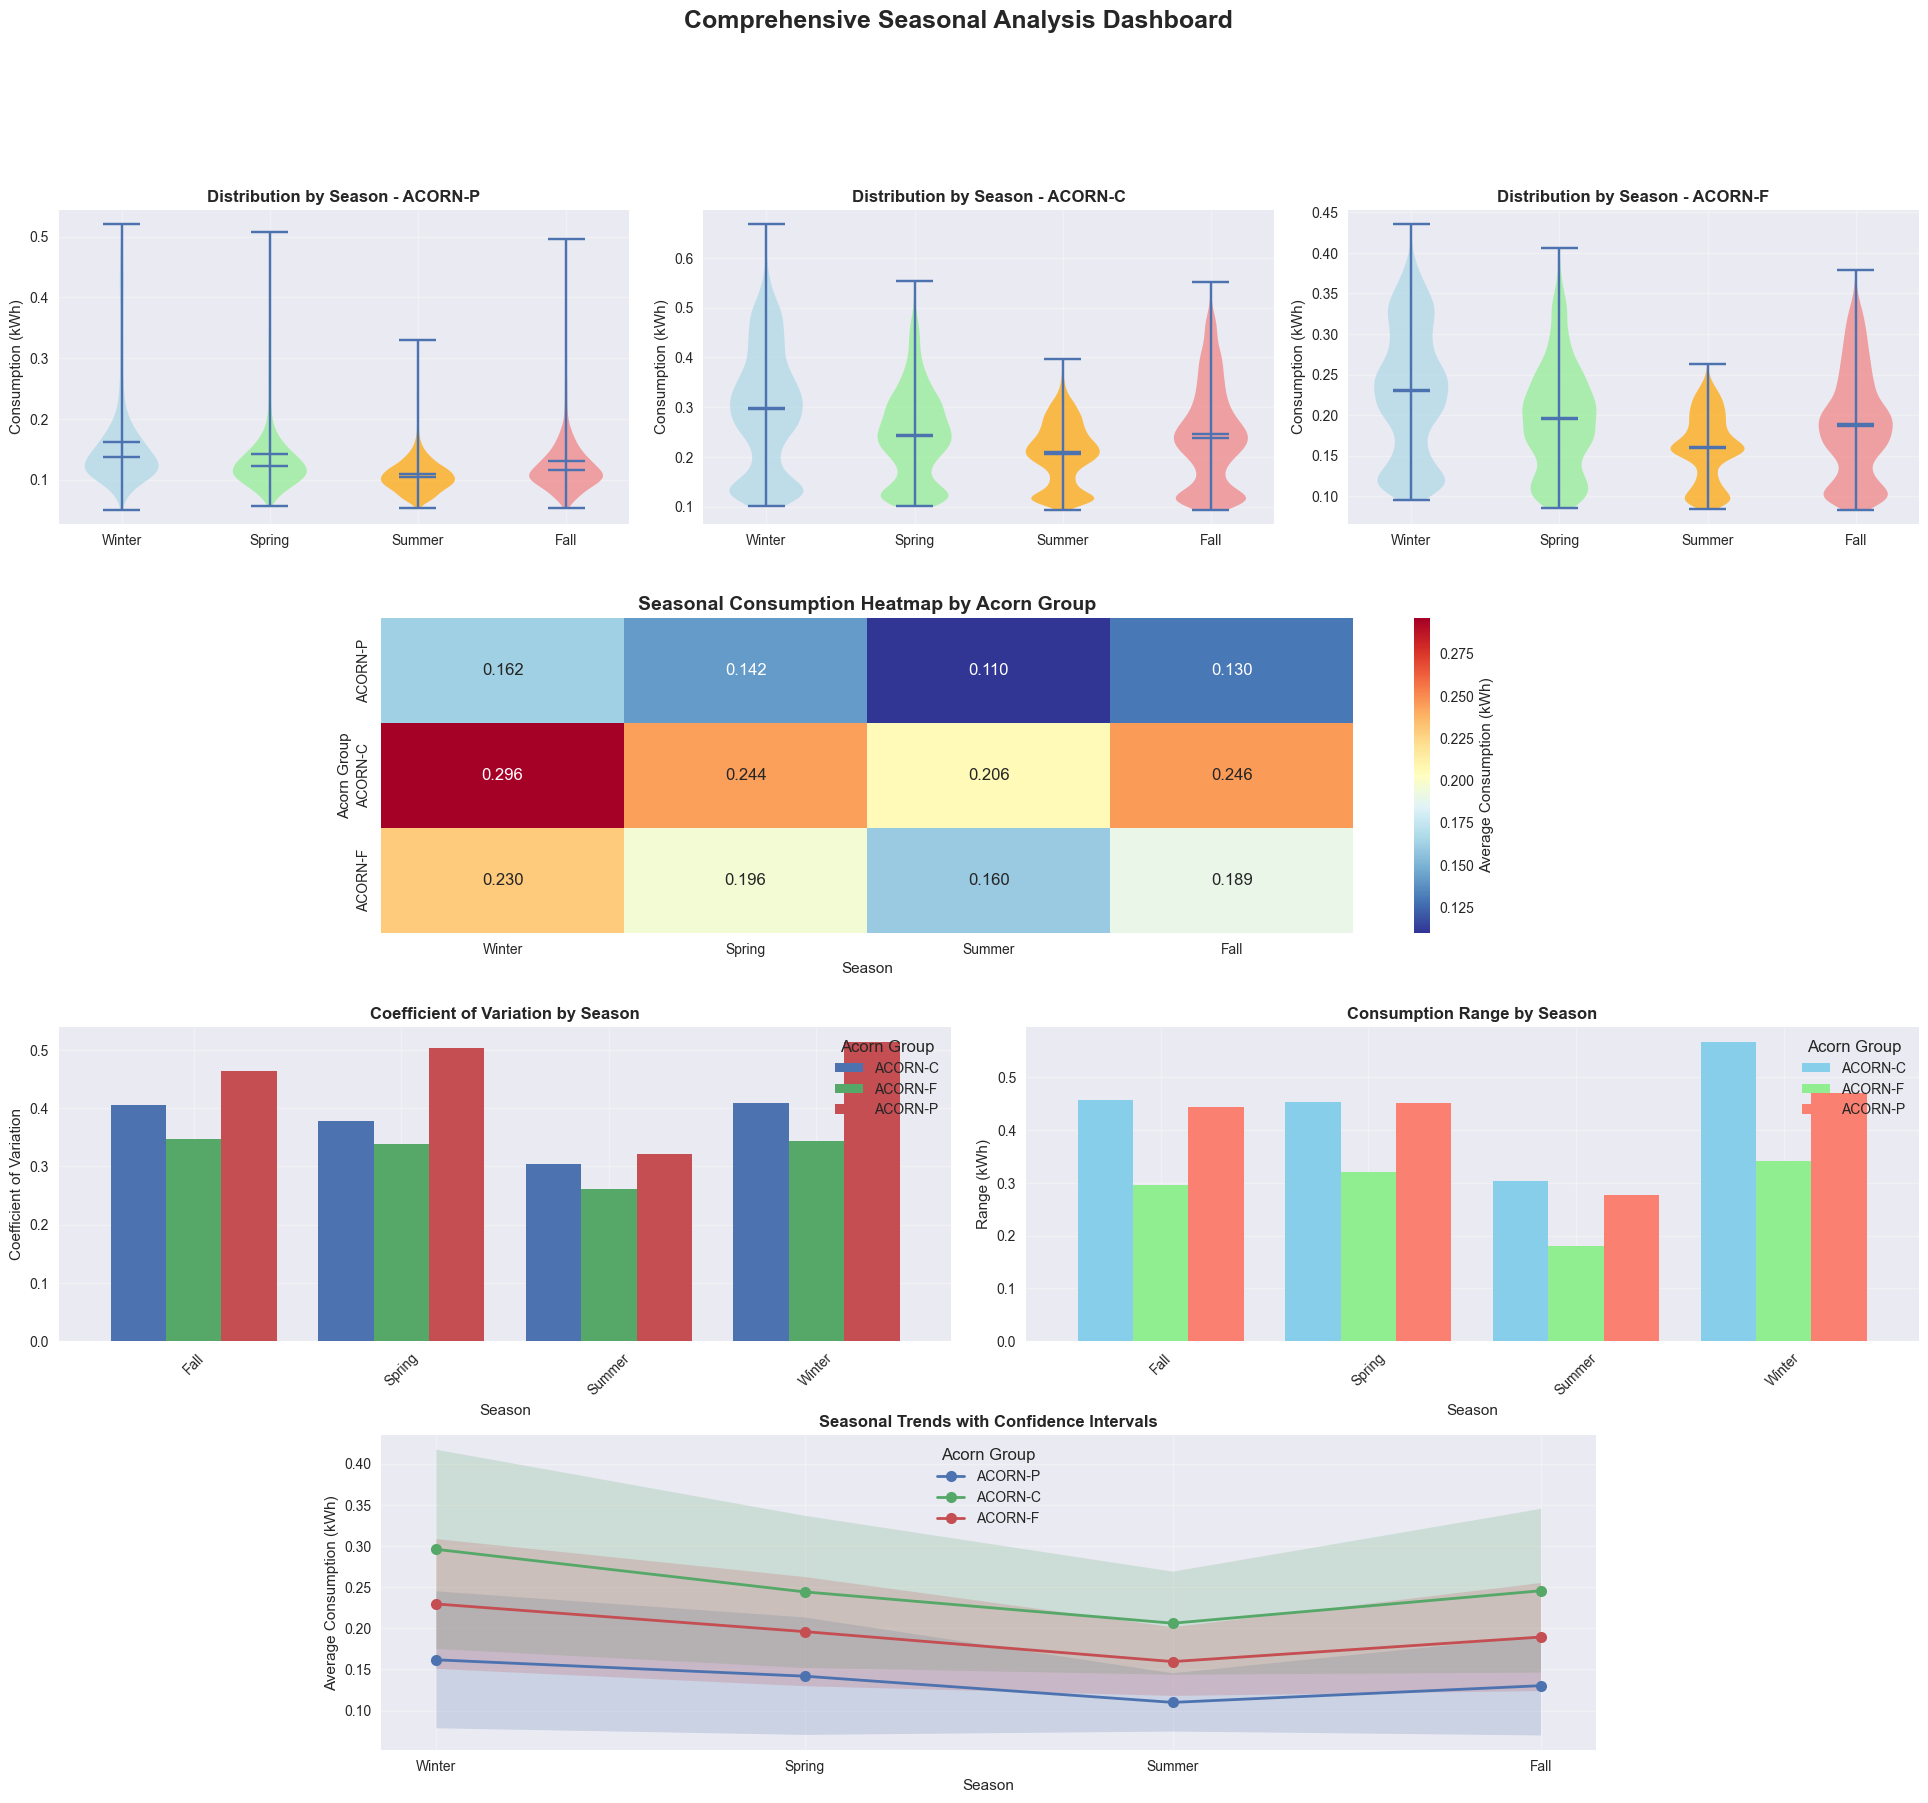


=== DETAILED SEASONAL ANALYSIS ===

Data period: 2012-06-30 22:00:00 to 2014-01-12 23:30:00
Total observations: 80,796

Seasonal distribution of observations:
Season
Fall      26208
Spring    13248
Summer    22188
Winter    19152
Name: count, dtype: int64

Seasonal variability analysis:

--- ACORN-P Seasonal Analysis ---
        Count    Mean  Median     Std     Min     Max      Q1      Q3     IQR  \
Season                                                                          
Fall     8736  0.1303  0.1153  0.0604  0.0527  0.4967  0.0978  0.1416  0.0438   
Spring   4416  0.1419  0.1227  0.0713  0.0570  0.5071  0.1044  0.1481  0.0437   
Summer   7396  0.1100  0.1046  0.0354  0.0531  0.3300  0.0887  0.1218  0.0331   
Winter   6384  0.1617  0.1371  0.0831  0.0506  0.5209  0.1140  0.1728  0.0588   

            CV   Range  
Season                  
Fall    0.4635  0.4440  
Spring  0.5025  0.4501  
Summer  0.3218  0.2769  
Winter  0.5139  0.4703  

--- ACORN-C Seasonal Analysis ---
    

In [107]:
# Advanced seasonal analysis with violin plots and distribution comparison

# Create a comprehensive seasonal analysis dashboard
fig = plt.figure(figsize=(24, 20))

# Create a grid layout - 4 rows, 6 columns for better centering
gs = fig.add_gridspec(4, 6, hspace=0.3, wspace=0.3)

# 1. Violin plots for each Acorn group (top row) - centered
for idx, acorn_group in enumerate(acorn_groups):
    # Distribute the 3 plots evenly in 6 columns: 0:2, 2:4, 4:6 (2 columns each)
    if idx == 0:
        ax = fig.add_subplot(gs[0, 0:2])
    elif idx == 1:
        ax = fig.add_subplot(gs[0, 2:4])
    else:  # idx == 2
        ax = fig.add_subplot(gs[0, 4:6])
    
    acorn_data = group_4_half_hourly[group_4_half_hourly['Acorn'] == acorn_group]
    
    # Create violin plot
    parts = ax.violinplot([acorn_data[acorn_data['Season'] == season]['Conso_moy'].values 
                          for season in SEASON_ORDER], 
                         positions=range(len(SEASON_ORDER)), 
                         showmeans=True, showmedians=True, showextrema=True)
    
    # Customize violin plot colors
    colors = ['lightblue', 'lightgreen', 'orange', 'lightcoral']
    for pc, color in zip(parts['bodies'], colors):
        pc.set_facecolor(color)
        pc.set_alpha(0.7)
    
    ax.set_xticks(range(len(SEASON_ORDER)))
    ax.set_xticklabels(SEASON_ORDER)
    ax.set_title(f'Distribution by Season - {acorn_group}', fontweight='bold')
    ax.set_ylabel('Consumption (kWh)')
    ax.grid(True, alpha=0.3)

# 2. Seasonal comparison heatmap (second row, spanning all columns) - centered
ax_heatmap = fig.add_subplot(gs[1, 1:5])  # Center the heatmap by using columns 1-4

# Create seasonal comparison matrix
seasonal_comparison = []
for acorn_group in acorn_groups:
    acorn_data = group_4_half_hourly[group_4_half_hourly['Acorn'] == acorn_group]
    row = []
    for season in SEASON_ORDER:
        mean_consumption = acorn_data[acorn_data['Season'] == season]['Conso_moy'].mean()
        row.append(mean_consumption)
    seasonal_comparison.append(row)

seasonal_df = pd.DataFrame(seasonal_comparison, 
                          index=acorn_groups, 
                          columns=SEASON_ORDER)

# Create heatmap
sns.heatmap(seasonal_df, annot=True, fmt='.3f', cmap='RdYlBu_r', 
           ax=ax_heatmap, cbar_kws={'label': 'Average Consumption (kWh)'})
ax_heatmap.set_title('Seasonal Consumption Heatmap by Acorn Group', 
                    fontsize=14, fontweight='bold')
ax_heatmap.set_xlabel('Season')
ax_heatmap.set_ylabel('Acorn Group')

# 3. Statistical comparison (third row)
# Coefficient of Variation by season
ax_cv = fig.add_subplot(gs[2, 0:3])  # Span first three columns
cv_data = []
for season in SEASON_ORDER:
    season_data = group_4_half_hourly[group_4_half_hourly['Season'] == season]
    for acorn_group in acorn_groups:
        acorn_season_data = season_data[season_data['Acorn'] == acorn_group]['Conso_moy']
        if len(acorn_season_data) > 0:
            cv = acorn_season_data.std() / acorn_season_data.mean()
            cv_data.append({'Season': season, 'Acorn': acorn_group, 'CV': cv})

cv_df = pd.DataFrame(cv_data)
cv_pivot = cv_df.pivot(index='Season', columns='Acorn', values='CV')
cv_pivot.plot(kind='bar', ax=ax_cv, width=0.8)
ax_cv.set_title('Coefficient of Variation by Season', fontweight='bold')
ax_cv.set_ylabel('Coefficient of Variation')
ax_cv.tick_params(axis='x', rotation=45)
ax_cv.legend(title='Acorn Group')
ax_cv.grid(True, alpha=0.3)

# Range analysis by season
ax_range = fig.add_subplot(gs[2, 3:6])  # Span last three columns
range_data = []
for season in SEASON_ORDER:
    season_data = group_4_half_hourly[group_4_half_hourly['Season'] == season]
    for acorn_group in acorn_groups:
        acorn_season_data = season_data[season_data['Acorn'] == acorn_group]['Conso_moy']
        if len(acorn_season_data) > 0:
            data_range = acorn_season_data.max() - acorn_season_data.min()
            range_data.append({'Season': season, 'Acorn': acorn_group, 'Range': data_range})

range_df = pd.DataFrame(range_data)
range_pivot = range_df.pivot(index='Season', columns='Acorn', values='Range')
range_pivot.plot(kind='bar', ax=ax_range, width=0.8, color=['skyblue', 'lightgreen', 'salmon'])
ax_range.set_title('Consumption Range by Season', fontweight='bold')
ax_range.set_ylabel('Range (kWh)')
ax_range.tick_params(axis='x', rotation=45)
ax_range.legend(title='Acorn Group')
ax_range.grid(True, alpha=0.3)

# 4. Seasonal trend analysis (fourth row, spanning all columns) - centered
ax_trend = fig.add_subplot(gs[3, 1:5])  # Center the trend plot by using columns 1-4
for acorn_group in acorn_groups:
    acorn_data = group_4_half_hourly[group_4_half_hourly['Acorn'] == acorn_group]
    seasonal_means = [acorn_data[acorn_data['Season'] == season]['Conso_moy'].mean() 
                     for season in SEASON_ORDER]
    ax_trend.plot(SEASON_ORDER, seasonal_means, marker='o', linewidth=2, 
                 markersize=8, label=acorn_group)
    
    # Add confidence intervals
    seasonal_stds = [acorn_data[acorn_data['Season'] == season]['Conso_moy'].std() 
                    for season in SEASON_ORDER]
    ax_trend.fill_between(SEASON_ORDER, 
                         [m - s for m, s in zip(seasonal_means, seasonal_stds)],
                         [m + s for m, s in zip(seasonal_means, seasonal_stds)],
                         alpha=0.2)

ax_trend.set_title('Seasonal Trends with Confidence Intervals', fontweight='bold')
ax_trend.set_ylabel('Average Consumption (kWh)')
ax_trend.set_xlabel('Season')
ax_trend.legend(title='Acorn Group')
ax_trend.grid(True, alpha=0.3)

plt.suptitle('Comprehensive Seasonal Analysis Dashboard', 
             fontsize=18, fontweight='bold', y=0.98)
plt.show()

# Print detailed seasonal statistics
print("\n=== DETAILED SEASONAL ANALYSIS ===")
print(f"\nData period: {group_4_half_hourly['DateTime'].min()} to {group_4_half_hourly['DateTime'].max()}")
print(f"Total observations: {len(group_4_half_hourly):,}")

print("\nSeasonal distribution of observations:")
print(group_4_half_hourly['Season'].value_counts().sort_index())

print("\nSeasonal variability analysis:")
for acorn_group in acorn_groups:
    print(f"\n--- {acorn_group} Seasonal Analysis ---")
    acorn_data = group_4_half_hourly[group_4_half_hourly['Acorn'] == acorn_group]
    
    seasonal_stats = acorn_data.groupby('Season')['Conso_moy'].agg([
        'count', 'mean', 'median', 'std', 'min', 'max',
        lambda x: x.quantile(0.25),
        lambda x: x.quantile(0.75)
    ]).round(4)
    
    seasonal_stats.columns = ['Count', 'Mean', 'Median', 'Std', 'Min', 'Max', 'Q1', 'Q3']
    seasonal_stats['IQR'] = (seasonal_stats['Q3'] - seasonal_stats['Q1']).round(4)
    seasonal_stats['CV'] = (seasonal_stats['Std'] / seasonal_stats['Mean']).round(4)
    seasonal_stats['Range'] = (seasonal_stats['Max'] - seasonal_stats['Min']).round(4)
    
    print(seasonal_stats)

## Anomalies and Confidence

17:17:38 - cmdstanpy - INFO - Chain [1] start processing
17:17:38 - cmdstanpy - INFO - Chain [1] done processing
17:17:38 - cmdstanpy - INFO - Chain [1] done processing


UK Bank Holidays for Prophet:
          ds                                       holiday  lower_window  \
0 2012-12-26                                    Boxing Day             0   
1 2012-12-25                                 Christmas Day             0   
2 2012-08-27                           Summer bank holiday             0   
3 2012-05-06  Queen?s Diamond Jubilee (extra bank holiday)             0   
4 2012-04-06          Spring bank holiday (substitute day)             0   

   upper_window  
0             1  
1             1  
2             1  
3             1  
4             1  

Daily consumption data shape: (1686, 13)
Holiday days in data: 42

=== ANOMALY DETECTION FOR ACORN-P ===


17:17:38 - cmdstanpy - INFO - Chain [1] start processing
17:17:38 - cmdstanpy - INFO - Chain [1] done processing
17:17:38 - cmdstanpy - INFO - Chain [1] done processing


Total days analyzed: 562
Isolation Forest anomalies: 57 (10.1%)
Prophet anomalies: 12 (2.1%)
Combined anomalies: 63 (11.2%)
Holiday anomalies: 14/14 (100.0%)

=== ANOMALY DETECTION FOR ACORN-C ===
Total days analyzed: 562
Isolation Forest anomalies: 57 (10.1%)
Prophet anomalies: 13 (2.3%)
Combined anomalies: 60 (10.7%)
Holiday anomalies: 14/14 (100.0%)

=== ANOMALY DETECTION FOR ACORN-F ===


17:17:38 - cmdstanpy - INFO - Chain [1] start processing
17:17:38 - cmdstanpy - INFO - Chain [1] done processing
17:17:38 - cmdstanpy - INFO - Chain [1] done processing


Total days analyzed: 562
Isolation Forest anomalies: 57 (10.1%)
Prophet anomalies: 13 (2.3%)
Combined anomalies: 62 (11.0%)
Holiday anomalies: 14/14 (100.0%)


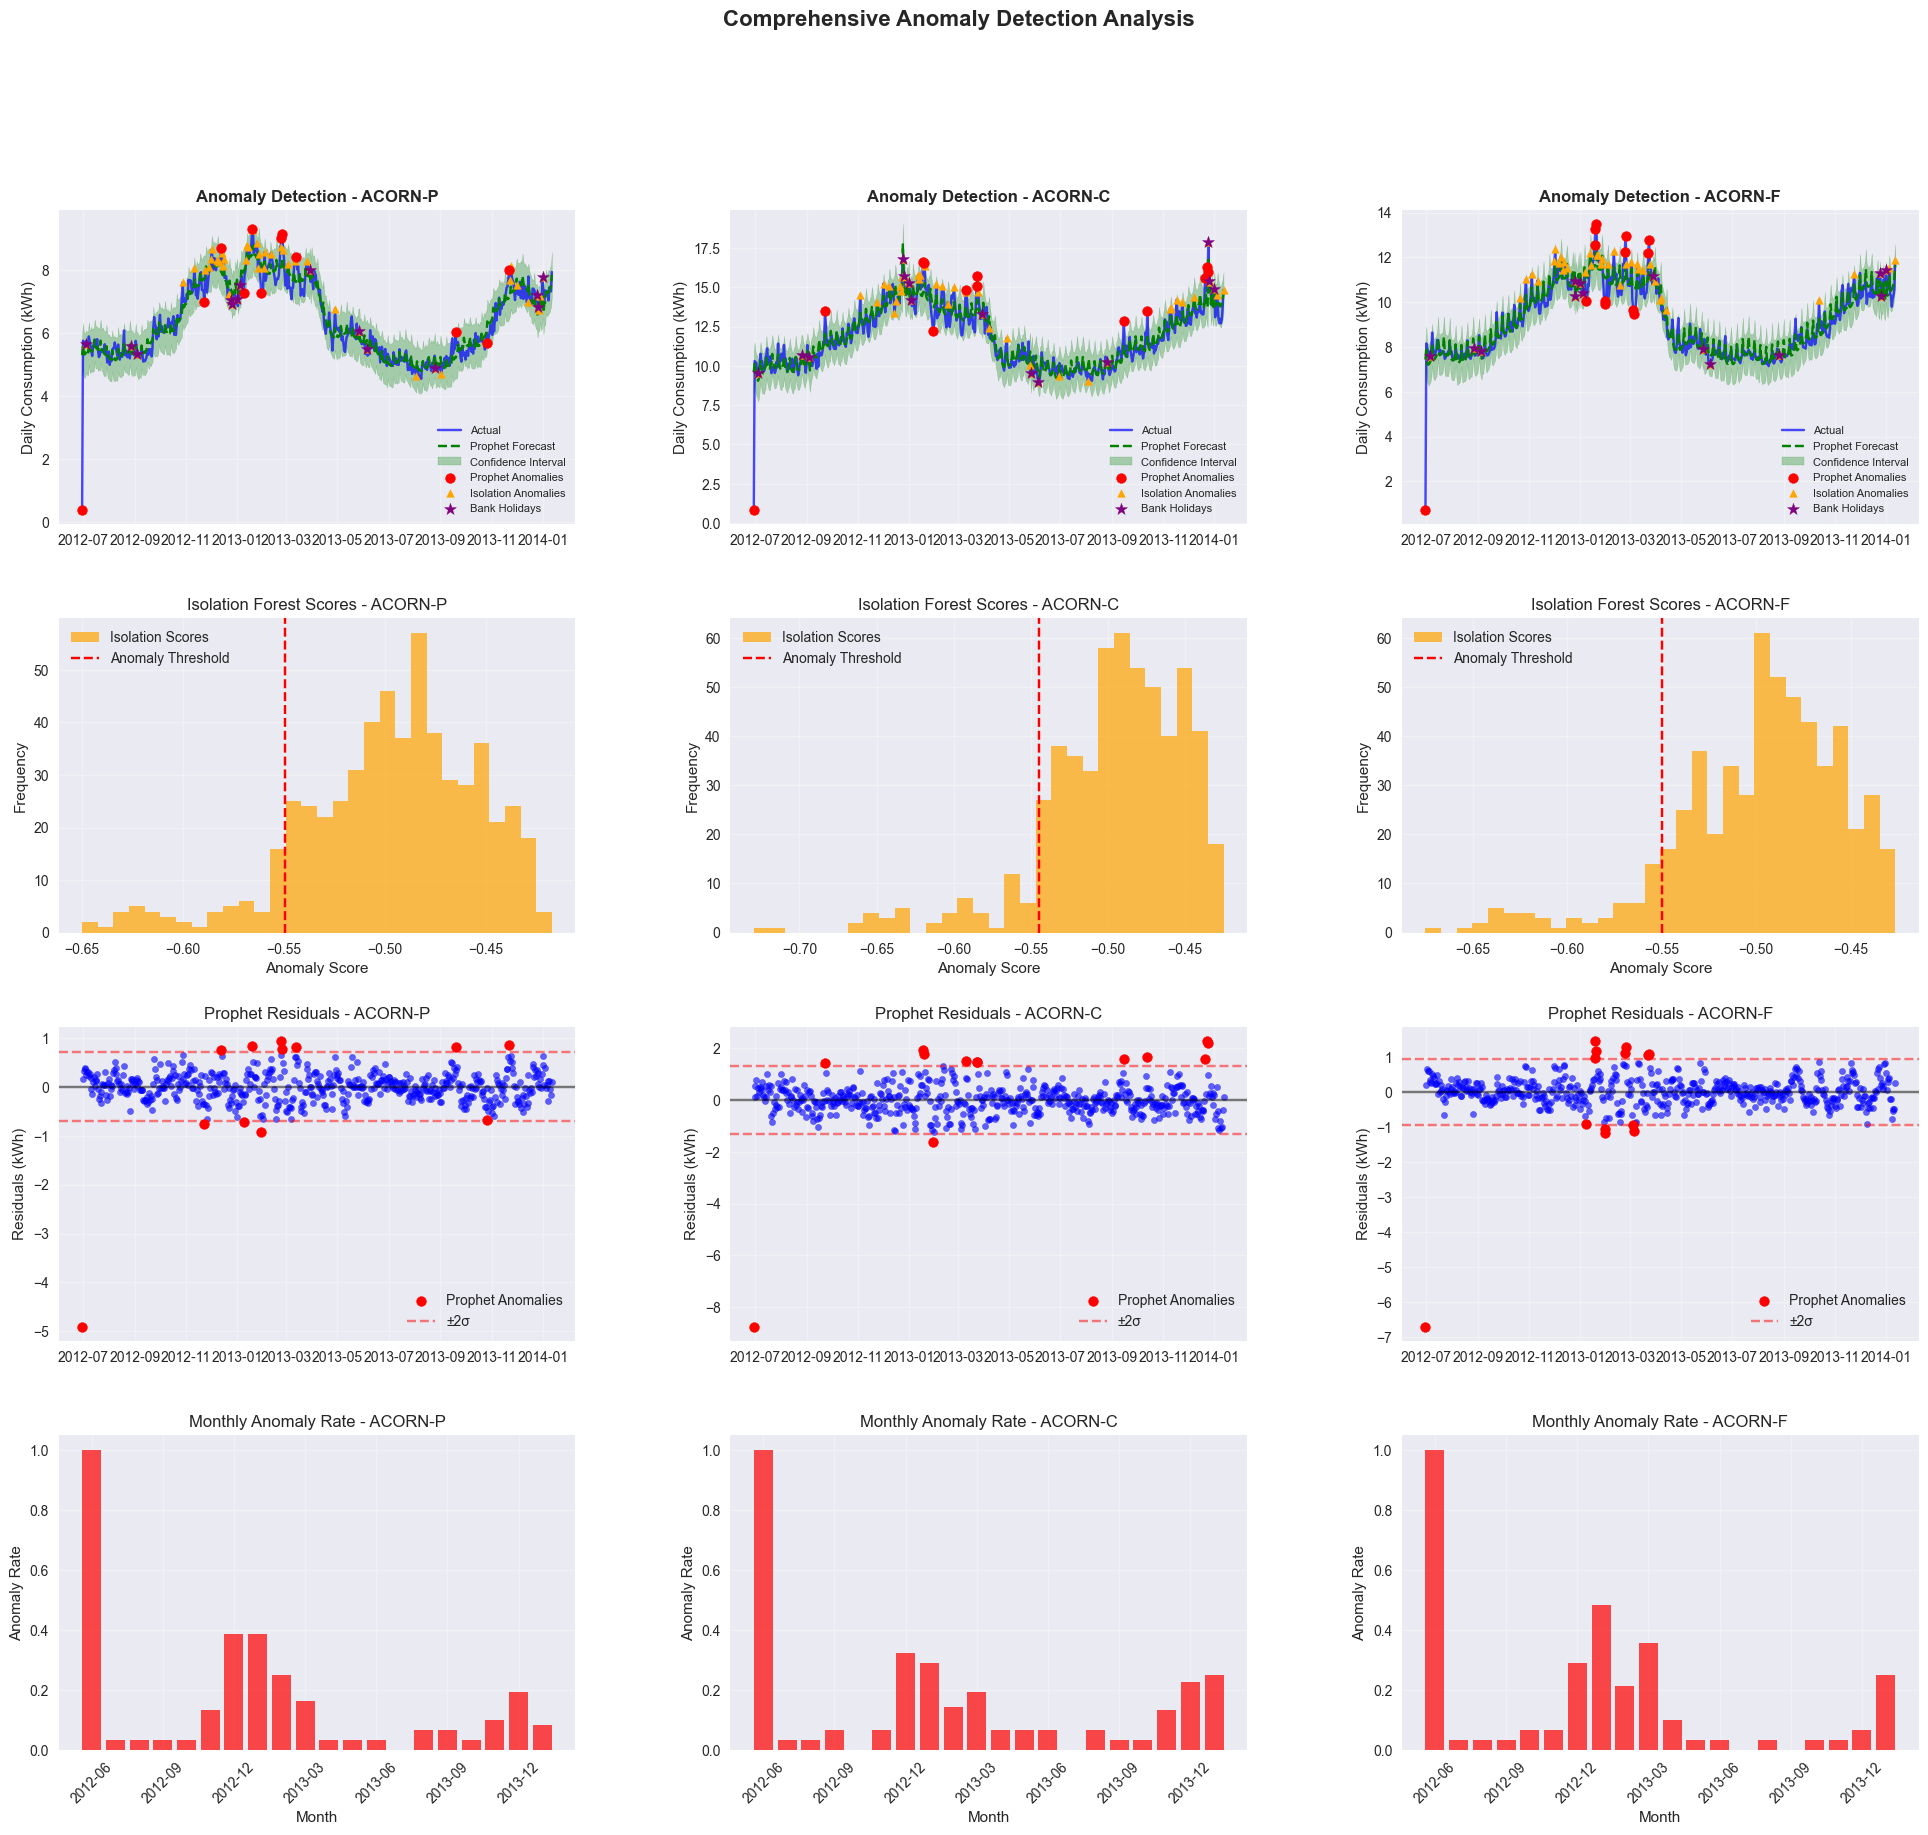


DETAILED ANOMALY ANALYSIS

ANOMALY DETECTION SUMMARY:
Acorn_Group  Total_Days  Isolation_Rate  Prophet_Rate  Combined_Rate  Holiday_Anomaly_Rate
    ACORN-P         562           10.14          2.14          11.21                 100.0
    ACORN-C         562           10.14          2.31          10.68                 100.0
    ACORN-F         562           10.14          2.31          11.03                 100.0

TOP 5 MOST EXTREME ANOMALIES BY GROUP

--- ACORN-P ---
Top anomalies (by Prophet severity):
  2012-06-30 (Saturday): 0.39 kWh (expected: 5.30, severity: 3.30) 
  2013-01-30 (Wednesday): 7.27 kWh (expected: 8.20, severity: 0.20) 
  2013-02-23 (Saturday): 9.03 kWh (expected: 8.09, severity: 0.18) 
  2013-11-22 (Friday): 7.99 kWh (expected: 7.14, severity: 0.14) 
  2013-03-12 (Tuesday): 8.43 kWh (expected: 7.62, severity: 0.12) 

--- ACORN-C ---
Top anomalies (by Prophet severity):
  2012-06-30 (Saturday): 0.85 kWh (expected: 9.62, severity: 2.86) 
  2013-12-24 (Tuesday): 15.9

In [108]:
# Isolation Forest / Prophet Anomaly Detection with UK Bank Holidays

warnings.filterwarnings('ignore')

# Prepare holiday data for Prophet
holidays = uk_bank_holidays[['Bank holidays', 'Type']].copy()
holidays.columns = ['ds', 'holiday']
holidays['lower_window'] = 0
holidays['upper_window'] = 1

print("UK Bank Holidays for Prophet:")
print(holidays.head())

# Ensure Date column is datetime type before processing
group_4_half_hourly_copy = group_4_half_hourly.copy()
if 'Date' in group_4_half_hourly_copy.columns:
    group_4_half_hourly_copy['Date'] = pd.to_datetime(group_4_half_hourly_copy['Date'])
if 'DateTime' in group_4_half_hourly_copy.columns:
    group_4_half_hourly_copy['DateTime'] = pd.to_datetime(group_4_half_hourly_copy['DateTime'])

# Prepare daily consumption data using utility function
daily_consumption = prepare_daily_consumption(group_4_half_hourly_copy)

# Ensure Date column is datetime type
daily_consumption['Date'] = pd.to_datetime(daily_consumption['Date'])

# Add holiday features
daily_consumption = add_holiday_features(daily_consumption, holidays)

print(f"\nDaily consumption data shape: {daily_consumption.shape}")
print(f"Holiday days in data: {daily_consumption['Is_Holiday'].sum()}")

# Perform anomaly detection for each Acorn group
anomaly_results = {}

for acorn_group in acorn_groups:
    print(f"\n=== ANOMALY DETECTION FOR {acorn_group} ===")
    
    # Filter data for current Acorn group
    acorn_data = daily_consumption[daily_consumption['Acorn'] == acorn_group].copy()
    acorn_data = acorn_data.sort_values('Date').reset_index(drop=True)
    
    # 1. Isolation Forest anomaly detection
    acorn_data = perform_isolation_forest_detection(acorn_data, ANOMALY_FEATURES)
    
    # 2. Prophet anomaly detection
    acorn_data = perform_prophet_detection(acorn_data, holidays)
    
    # 3. Combined anomaly detection
    acorn_data['Is_Combined_Anomaly'] = (
        acorn_data['Is_Isolation_Anomaly'] | acorn_data['Is_Prophet_Anomaly']
    )
    
    # Store results
    anomaly_results[acorn_group] = acorn_data
    
    # Print summary statistics
    total_days = len(acorn_data)
    isolation_anomalies_count = acorn_data['Is_Isolation_Anomaly'].sum()
    prophet_anomalies_count = acorn_data['Is_Prophet_Anomaly'].sum()
    combined_anomalies_count = acorn_data['Is_Combined_Anomaly'].sum()
    
    print(f"Total days analyzed: {total_days}")
    print(f"Isolation Forest anomalies: {isolation_anomalies_count} ({isolation_anomalies_count/total_days*100:.1f}%)")
    print(f"Prophet anomalies: {prophet_anomalies_count} ({prophet_anomalies_count/total_days*100:.1f}%)")
    print(f"Combined anomalies: {combined_anomalies_count} ({combined_anomalies_count/total_days*100:.1f}%)")
    
    # Holiday analysis
    holiday_anomalies = acorn_data[acorn_data['Is_Holiday'] == 1]['Is_Combined_Anomaly'].sum()
    total_holidays = acorn_data['Is_Holiday'].sum()
    if total_holidays > 0:
        print(f"Holiday anomalies: {holiday_anomalies}/{total_holidays} ({holiday_anomalies/total_holidays*100:.1f}%)")

# Create comprehensive visualization
create_anomaly_visualization(anomaly_results, acorn_groups)

# Print comprehensive summary
summary_df = print_anomaly_summary(anomaly_results, acorn_groups)

# Most extreme anomalies
print("\n" + "="*60)
print("TOP 5 MOST EXTREME ANOMALIES BY GROUP")
print("="*60)

for acorn_group in acorn_groups:
    print(f"\n--- {acorn_group} ---")
    data = anomaly_results[acorn_group]
    
    # Get top anomalies by Prophet severity
    top_anomalies = data[data['Is_Combined_Anomaly']].nlargest(5, 'Prophet_Anomaly_Severity')
    
    if len(top_anomalies) > 0:
        print("Top anomalies (by Prophet severity):")
        for _, row in top_anomalies.iterrows():
            holiday_status = "🎄 HOLIDAY" if row['Is_Holiday'] else ""
            day_name = row['Date'].strftime('%A')
            print(f"  {row['Date'].strftime('%Y-%m-%d')} ({day_name}): "
                  f"{row['Daily_Sum']:.2f} kWh "
                  f"(expected: {row['Prophet_Predicted']:.2f}, "
                  f"severity: {row['Prophet_Anomaly_Severity']:.2f}) {holiday_status}")
    else:
        print("No combined anomalies detected.")

# Seasonal anomaly patterns
print("\n" + "="*60)
print("SEASONAL ANOMALY PATTERNS")
print("="*60)

for acorn_group in acorn_groups:
    print(f"\n--- {acorn_group} ---")
    data = anomaly_results[acorn_group]
    
    seasonal_anomalies = data.groupby('Season').agg({
        'Is_Combined_Anomaly': ['sum', 'count'],
        'Prophet_Anomaly_Severity': 'mean'
    }).round(3)
    
    seasonal_anomalies.columns = ['Anomalies', 'Total_Days', 'Avg_Severity']
    seasonal_anomalies['Anomaly_Rate'] = (seasonal_anomalies['Anomalies'] / 
                                         seasonal_anomalies['Total_Days'] * 100).round(2)
    
    print(seasonal_anomalies)

# Results stored in 'anomaly_results' dictionary

In [109]:
# 🔧 CONFIGURATION CELL - Adjust parameters here
# This cell allows easy configuration of analysis parameters

# Plot configuration
PLOT_STYLE = 'seaborn-v0_8'
FIGURE_DPI = 100
FONT_SIZE = 12

# Anomaly detection configuration
ISOLATION_CONTAMINATION = 0.1  # Proportion of outliers in Isolation Forest
PROPHET_INTERVAL_WIDTH = 0.95   # Confidence interval width for Prophet

# Color palettes
ACORN_COLORS = ['skyblue', 'lightgreen', 'salmon']
SEASON_COLORS = ['lightblue', 'lightgreen', 'orange', 'lightcoral']

# Set global plot style
plt.style.use(PLOT_STYLE)
plt.rcParams['font.size'] = FONT_SIZE
plt.rcParams['figure.dpi'] = FIGURE_DPI

print("Configuration loaded successfully!")
print(f"Plot style: {PLOT_STYLE}")
print(f"Isolation Forest contamination: {ISOLATION_CONTAMINATION}")
print(f"Prophet interval width: {PROPHET_INTERVAL_WIDTH}")

Configuration loaded successfully!
Plot style: seaborn-v0_8
Isolation Forest contamination: 0.1
Prophet interval width: 0.95
